In [1]:
using Plots
using LinearAlgebra
using Revise
using Optim
#using FFTW
using Nevanlinna
using Zygote
using LaTeXStrings
using MultiFloats
using SparseIR

In [2]:
# Set work data Type
#T = Float64x2
T = BigFloat

BigFloat

In [3]:
beta = 100
wmax = 10
IR_basis_set = FiniteTempBasisSet(Float64(beta), Float64(wmax), 1e-15) 
;

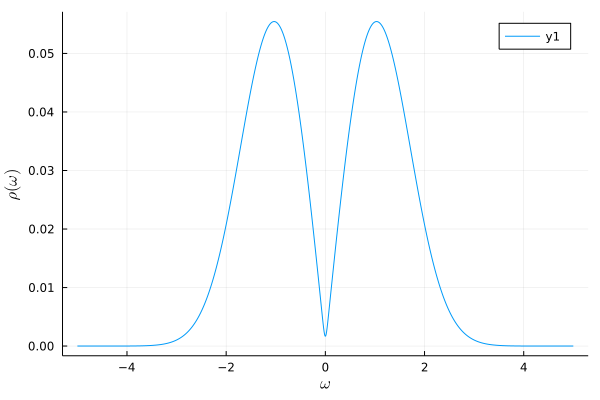

In [4]:
gaussian(x, mu, sigma) = exp(-((x-mu)/sigma)^2)/(sqrt(π)*sigma)
lorentzian(x, mu, gamma) = gamma/(pi*(gamma^2+(x-mu)^2))

#rho(omega) = gaussian(omega, 0.0, 0.15)  
rho(omega) = (0.1*gaussian(omega, 1, 1) - 0.1*gaussian(omega, -1, 1))/tanh(0.5*beta*omega)


omegas = LinRange(-5, 5, 1000)
#plot(omegas, rho.(omegas).*tanh.(0.5*beta*omegas), xlabel=latexstring("\\omega"), ylabel=latexstring("\\rho(\\omega)"))
plot(omegas, rho.(omegas), xlabel=latexstring("\\omega"), ylabel=latexstring("\\rho(\\omega)"))

In [5]:
rhol_f = [overlap(IR_basis_set.basis_f.v[l], rho) for l in 1:length(IR_basis_set.basis_f)]
rhol_b = [overlap(IR_basis_set.basis_b.v[l], rho) for l in 1:length(IR_basis_set.basis_b)]
rhol_f == rhol_b

true

In [6]:
gl_f = - IR_basis_set.basis_f.s .* rhol_f
gl_b = - IR_basis_set.basis_b.s .* rhol_b
gl_f == gl_b

true

In [7]:
rhol = [overlap(IR_basis_set.basis_b.v[l], rho) for l in 1:length(IR_basis_set.basis_b)]
gl = - IR_basis_set.basis_b.s .* rhol
;

In [8]:
gw = evaluate(IR_basis_set.smpl_wn_f, gl)
hnw = length(IR_basis_set.smpl_wn_f.sampling_points)÷2

36

In [9]:
sum = -dot(IR_basis_set.basis_f.u(beta), gl) - dot(IR_basis_set.basis_f.u(0), gl)

0.16859477735722422

In [10]:
setprecision(512)

512

In [11]:
test_gw   = Array{Complex{T}}(undef, hnw) 
test_smpl = Array{Complex{T}}(undef, hnw) 
;

In [17]:
gw

72-element Vector{ComplexF64}:
    3.23277694945387e-20 + 0.0011703570278062312im
  -9.932021649074423e-20 + 0.003534884302307902im
  -8.594424953418551e-19 + 0.005956441056492285im
  2.4946569507147187e-18 + 0.008494024491521004im
  2.1033283226361962e-20 + 0.011164370117650747im
  1.7370320530672384e-18 + 0.013989199411275285im
  1.9421944243800466e-18 + 0.01705617585462218im
   -5.61525908356855e-18 + 0.020348059697855206im
 -1.0948353110916365e-17 + 0.024066823076950485im
  2.3932514213418887e-18 + 0.027909306252135502im
 -2.9790995947753862e-18 + 0.032003543386319666im
 -1.2001464139325087e-18 + 0.03691055469497423im
  1.6722826828077492e-19 + 0.041582649903171204im
                         ⋮
 -1.2001464139325087e-18 - 0.03691055469497423im
 -2.9790995947753862e-18 - 0.032003543386319666im
  2.3932514213418887e-18 - 0.027909306252135502im
 -1.0948353110916365e-17 - 0.024066823076950485im
   -5.61525908356855e-18 - 0.020348059697855206im
  1.9421944243800466e-18 - 0.017056175854622

In [15]:
for i in 1:hnw
    test_smpl[i]= SparseIR.valueim(IR_basis_set.smpl_wn_f.sampling_points[hnw+i], SparseIR.β(IR_basis_set))
    test_gw[i]  = gw[hnw+i]
end

In [16]:
test_gw

36-element Vector{Complex{BigFloat}}:
      -2.229594055728188470727303258755475961357798940216771999001110771132516674697399139404296875e-17 - 0.0201290540068751744318120699972496367990970611572265625im
       3.577430331177143073074937130969523998824037723715842107541362793199368752539157867431640625e-17 - 0.03965421136383324995922095013156649656593799591064453125im
     -9.4717518199420387292715509751727964466185189740753645748494449208010337315499782562255859375e-18 - 0.05253056576134203237149478127321344800293445587158203125im
       -3.56728052169374353947609044395758587065794816971416036910369484758120961487293243408203125e-17 - 0.06164490818026376051097514618959394283592700958251953125im
            2.4839594320108493819117610232356781258241458683333480195187803474254906177520751953125e-17 - 0.068260537619153904831392765117925591766834259033203125im
            2.3038285356885592860909575345677028999287244866167601031747835804708302021026611328125e-17 - 0.0730887061332357312881

In [13]:
N_real    =  1000
omega_max =  10.0
eta       =  0.001
H_max     =  50
ab_coeff  = zeros(ComplexF64, 2*H_max) 
lambda    = 1e-5
iter_tol  = 1000
N_imag    =  Nevanlinna.calc_opt_N_imag(hnw, test_smpl, test_gw)
println("N_imag $(N_imag)")

N_imag is setted as 31
N_imag 31


In [14]:
@time sol = Nevanlinna.NevanlinnaSolver(N_imag, test_smpl, test_gw, N_real, omega_max, eta, sum, H_max, iter_tol, lambda, true)
;

Pick matrix is positive semi-definite.
H=1
Iter     Function value   Gradient norm 
     0     5.767694e-03     2.740452e-02
 * time: 0.026197195053100586
     1     2.045719e-03     1.001535e-02
 * time: 1.7830171585083008
     2     1.700121e-03     1.036115e-02
 * time: 2.101344108581543
     3     9.817062e-04     1.303892e-03
 * time: 2.604443073272705
     4     9.475190e-04     2.585186e-04
 * time: 2.9352622032165527
     5     9.468569e-04     4.886759e-05
 * time: 3.1641690731048584
     6     9.468380e-04     5.000860e-06
 * time: 3.531513214111328
     7     9.468378e-04     7.532304e-07
 * time: 3.84407901763916
     8     9.468378e-04     7.201636e-08
 * time: 4.190122127532959
     9     9.468378e-04     1.040462e-08
 * time: 4.439817190170288
    10     9.468378e-04     8.572403e-10
 * time: 4.6360859870910645
max_theta=0.197559542727185747134071976242748043247626638966987191398589685016163682922597383386539005204141179953660303764721066899294691460693100730739789478199

In [15]:
@time Nevanlinna.solve!(sol)
;

H=1
Iter     Function value   Gradient norm 
     0     9.468378e-04     8.572403e-10
 * time: 0.00041413307189941406
max_theta=0.197559542727185747134071976242748043247626638966987191398589685016163682922597383386539005204141179953660303764721066899294691460693100730739789478199082033
hardy optimization was success.
H=2
Iter     Function value   Gradient norm 
     0     9.468378e-04     7.520382e-03
 * time: 0.00033283233642578125
     1     3.542175e-04     4.035273e-03
 * time: 0.6160578727722168
     2     2.207042e-04     1.385295e-03
 * time: 1.3106749057769775
     3     1.889728e-04     4.042785e-04
 * time: 1.7752389907836914
     4     1.869900e-04     3.515687e-04
 * time: 2.4376089572906494
     5     1.855087e-04     4.541176e-04
 * time: 2.88291597366333
     6     1.795748e-04     5.029822e-04
 * time: 3.609975814819336
     7     1.699187e-04     4.427892e-05
 * time: 4.187371015548706
     8     1.698754e-04     6.197381e-06
 * time: 4.471469879150391
     9     1.698

    10     3.421513e-06     1.403351e-05
 * time: 8.145655155181885
    11     3.416914e-06     4.538529e-06
 * time: 9.01828908920288
    12     3.416385e-06     1.812220e-06
 * time: 10.003458976745605
    13     3.416321e-06     2.051333e-06
 * time: 10.769889116287231
    14     3.404057e-06     1.693148e-05
 * time: 12.517868995666504
    15     3.397055e-06     1.392629e-05
 * time: 13.164834022521973
    16     3.351094e-06     1.485133e-05
 * time: 14.20347809791565
    17     3.345076e-06     1.480976e-05
 * time: 14.792707204818726
    18     3.246572e-06     2.525324e-05
 * time: 16.036007165908813
    19     3.225655e-06     7.277243e-07
 * time: 16.67964220046997
    20     3.225650e-06     7.046720e-07
 * time: 17.327182054519653
    21     3.222595e-06     4.499685e-06
 * time: 18.747749090194702
    22     3.221091e-06     4.680731e-08
 * time: 19.347978115081787
    23     3.221091e-06     2.311661e-08
 * time: 19.935322046279907
    24     3.221090e-06     1.142058e-0

    30     3.131192e-06     3.937454e-08
 * time: 31.084464073181152
    31     3.131141e-06     1.195723e-06
 * time: 32.85090899467468
    32     3.130462e-06     3.602243e-07
 * time: 33.86394715309143
    33     3.130456e-06     3.096621e-08
 * time: 34.62723207473755
    34     3.130456e-06     3.109899e-08
 * time: 35.38056707382202
    35     3.130445e-06     5.199394e-07
 * time: 37.2039749622345
    36     3.128069e-06     3.131257e-06
 * time: 38.73874115943909
    37     3.127671e-06     4.676403e-08
 * time: 39.463561058044434
    38     3.127671e-06     1.495175e-09
 * time: 39.961533069610596
max_theta=0.471915835955335771373485928346007426270439820867159639049093055576794783708466385837899600562153432921861514382114903541021353090039442780064791275734248837
hardy optimization was success.
H=11
Iter     Function value   Gradient norm 
     0     3.127671e-06     3.468328e-06
 * time: 0.00022077560424804688
     1     3.127636e-06     1.820400e-06
 * time: 1.15126395225524

    20     3.126271e-06     2.826415e-07
 * time: 23.359803915023804
    21     3.126269e-06     2.385230e-07
 * time: 24.603455066680908
    22     3.126265e-06     2.360676e-07
 * time: 25.51184606552124
    23     3.126262e-06     2.648588e-07
 * time: 27.27913784980774
    24     3.126258e-06     2.113211e-07
 * time: 28.35548686981201
    25     3.126254e-06     2.735464e-07
 * time: 30.037587881088257
    26     3.126246e-06     2.018721e-07
 * time: 30.99031090736389
    27     3.126245e-06     2.011656e-07
 * time: 32.19774794578552
    28     3.126235e-06     2.320801e-07
 * time: 33.33091187477112
    29     3.126234e-06     2.190957e-07
 * time: 34.179713010787964
    30     3.126226e-06     1.589714e-07
 * time: 35.62169098854065
    31     3.126225e-06     1.753215e-07
 * time: 36.420583963394165
    32     3.126220e-06     2.721851e-07
 * time: 37.78097987174988
    33     3.126214e-06     9.941150e-08
 * time: 38.56215286254883
    34     3.126214e-06     9.989279e-08
 *

    32     3.125131e-06     3.347551e-07
 * time: 43.27324604988098
    33     3.125130e-06     3.089405e-07
 * time: 44.26251006126404
    34     3.125117e-06     3.537525e-07
 * time: 45.879884004592896
    35     3.125112e-06     1.926797e-07
 * time: 46.823686838150024
    36     3.125111e-06     1.611436e-07
 * time: 48.074169874191284
    37     3.125102e-06     1.055425e-07
 * time: 49.31972599029541
    38     3.125101e-06     8.597439e-08
 * time: 50.27483797073364
    39     3.125100e-06     2.143871e-07
 * time: 51.9031708240509
    40     3.125093e-06     5.598036e-08
 * time: 53.22197484970093
    41     3.125093e-06     5.419045e-08
 * time: 54.16202187538147
    42     3.125093e-06     1.159428e-07
 * time: 56.52180004119873
    43     3.125078e-06     1.694267e-07
 * time: 58.81630206108093
    44     3.125077e-06     2.595719e-08
 * time: 60.10155987739563
    45     3.125077e-06     2.657573e-08
 * time: 61.32821297645569
    46     3.125075e-06     1.769232e-07
 * ti

    33     3.123901e-06     3.494665e-07
 * time: 45.754852056503296
    34     3.123881e-06     2.416892e-07
 * time: 47.12216114997864
    35     3.123880e-06     2.318785e-07
 * time: 48.168957233428955
    36     3.123870e-06     3.444791e-07
 * time: 49.85082507133484
    37     3.123861e-06     3.185871e-07
 * time: 50.940049171447754
    38     3.123860e-06     3.101848e-07
 * time: 52.331730127334595
    39     3.123832e-06     2.520554e-07
 * time: 54.05220103263855
    40     3.123829e-06     2.371883e-07
 * time: 55.078267097473145
    41     3.123827e-06     2.154661e-07
 * time: 56.438783168792725
    42     3.123790e-06     3.014034e-07
 * time: 57.855117082595825
    43     3.123785e-06     2.200723e-07
 * time: 58.85814309120178
    44     3.123783e-06     2.092763e-07
 * time: 60.267757177352905
    45     3.123751e-06     2.774482e-07
 * time: 61.65121507644653
    46     3.123747e-06     1.481882e-07
 * time: 62.68850803375244
    47     3.123745e-06     1.734757e-07

     8     3.120836e-06     8.005495e-07
 * time: 10.799637079238892
     9     3.120816e-06     9.706698e-07
 * time: 12.219906091690063
    10     3.120805e-06     8.497913e-07
 * time: 13.350878953933716
    11     3.120797e-06     9.162828e-07
 * time: 14.483066082000732
    12     3.120777e-06     7.706128e-07
 * time: 15.900085926055908
    13     3.120766e-06     6.717682e-07
 * time: 17.340596914291382
    14     3.120756e-06     7.911483e-07
 * time: 18.420413970947266
    15     3.120738e-06     7.939251e-07
 * time: 19.839216947555542
    16     3.120729e-06     6.052841e-07
 * time: 21.30500888824463
    17     3.120712e-06     7.233052e-07
 * time: 22.373875856399536
    18     3.120696e-06     5.693514e-07
 * time: 23.831594944000244
    19     3.120691e-06     6.640884e-07
 * time: 24.87121891975403
    20     3.120669e-06     5.411295e-07
 * time: 26.31486701965332
    21     3.120665e-06     5.099110e-07
 * time: 27.40328598022461
    22     3.120651e-06     3.791155e-

    41     3.117835e-06     4.646218e-07
 * time: 58.46627593040466
    42     3.117826e-06     3.860957e-07
 * time: 60.032559871673584
    43     3.117743e-06     4.246456e-07
 * time: 61.5077109336853
    44     3.117733e-06     3.516422e-07
 * time: 62.60614585876465
    45     3.117730e-06     3.405906e-07
 * time: 64.12483286857605
    46     3.117698e-06     2.993383e-07
 * time: 65.74352502822876
    47     3.117689e-06     2.911150e-07
 * time: 66.87421989440918
    48     3.117688e-06     3.033373e-07
 * time: 67.98052883148193
    49     3.117659e-06     6.221714e-07
 * time: 69.89811682701111
    50     3.117591e-06     2.877889e-07
 * time: 70.98589897155762
    51     3.117588e-06     2.777734e-07
 * time: 72.14079880714417
    52     3.117581e-06     2.328825e-07
 * time: 74.07887601852417
    53     3.117488e-06     5.605095e-07
 * time: 75.59041094779968
    54     3.117468e-06     2.202748e-07
 * time: 76.72255492210388
    55     3.117467e-06     2.367704e-07
 * time

    65     3.113554e-06     9.124085e-08
 * time: 81.00929284095764
    66     3.113553e-06     8.731035e-08
 * time: 82.46534085273743
    67     3.113553e-06     8.754988e-08
 * time: 83.34278082847595
    68     3.113553e-06     8.250519e-08
 * time: 84.77869391441345
    69     3.113553e-06     8.293835e-08
 * time: 86.38184881210327
    70     3.113552e-06     7.131123e-08
 * time: 87.77009987831116
    71     3.113551e-06     8.927391e-08
 * time: 88.92100501060486
    72     3.113549e-06     1.107869e-07
 * time: 90.17780780792236
    73     3.113548e-06     1.516908e-07
 * time: 91.46661496162415
    74     3.113547e-06     1.417959e-07
 * time: 92.86387181282043
    75     3.113546e-06     1.394057e-07
 * time: 93.7953519821167
    76     3.113546e-06     1.183452e-07
 * time: 95.1561529636383
    77     3.113546e-06     1.309273e-07
 * time: 96.50901579856873
    78     3.113545e-06     1.211273e-07
 * time: 97.88657593727112
    79     3.113544e-06     1.063752e-07
 * time: 

   185     3.113452e-06     2.670796e-08
 * time: 196.43247294425964
   186     3.113452e-06     2.578557e-08
 * time: 197.16815996170044
   187     3.113452e-06     2.561733e-08
 * time: 198.23488998413086
   188     3.113451e-06     2.733871e-08
 * time: 199.30748796463013
   189     3.113451e-06     2.779818e-08
 * time: 200.35575580596924
   190     3.113450e-06     3.278896e-08
 * time: 201.46125888824463
   191     3.113449e-06     3.253912e-08
 * time: 202.50564193725586
   192     3.113446e-06     3.322078e-08
 * time: 203.5420458316803
   193     3.113442e-06     2.912166e-08
 * time: 204.62520384788513
   194     3.113438e-06     2.491836e-08
 * time: 205.70884490013123
   195     3.113436e-06     2.173599e-08
 * time: 206.41761898994446
   196     3.113436e-06     2.146798e-08
 * time: 207.5471978187561
   197     3.113436e-06     2.063645e-08
 * time: 208.54933881759644
   198     3.113436e-06     2.084385e-08
 * time: 209.62564301490784
   199     3.113436e-06     2.107797

    33     3.112473e-06     9.724902e-07
 * time: 42.46647787094116
    34     3.112454e-06     9.290357e-07
 * time: 43.59354901313782
    35     3.112429e-06     1.245534e-06
 * time: 44.71338891983032
    36     3.112379e-06     1.296795e-06
 * time: 45.82652688026428
    37     3.112340e-06     9.021840e-07
 * time: 46.91591501235962
    38     3.112323e-06     8.493333e-07
 * time: 47.603901863098145
    39     3.112297e-06     1.202250e-06
 * time: 48.71715688705444
    40     3.112253e-06     1.064813e-06
 * time: 50.12756395339966
    41     3.112203e-06     1.119936e-06
 * time: 51.46389198303223
    42     3.112184e-06     1.018876e-06
 * time: 52.36054992675781
    43     3.112165e-06     8.688703e-07
 * time: 53.27894687652588
    44     3.112153e-06     9.908132e-07
 * time: 54.59140706062317
    45     3.112134e-06     8.849487e-07
 * time: 55.724950075149536
    46     3.112116e-06     8.646350e-07
 * time: 56.80789399147034
    47     3.112084e-06     1.216853e-06
 * ti

   153     3.109770e-06     3.827392e-07
 * time: 165.8067090511322
   154     3.109763e-06     3.839687e-07
 * time: 166.93663692474365
   155     3.109758e-06     3.833706e-07
 * time: 167.6972529888153
   156     3.109747e-06     3.812315e-07
 * time: 168.80949306488037
   157     3.109739e-06     3.793303e-07
 * time: 169.56885290145874
   158     3.109723e-06     3.674526e-07
 * time: 170.6791799068451
   159     3.109711e-06     3.653994e-07
 * time: 171.41541004180908
   160     3.109686e-06     3.554249e-07
 * time: 172.5373890399933
   161     3.109668e-06     3.524026e-07
 * time: 173.27010202407837
   162     3.109625e-06     3.676999e-07
 * time: 174.3536729812622
   163     3.109589e-06     3.674230e-07
 * time: 175.56287288665771
   164     3.109451e-06     2.980537e-07
 * time: 177.3483419418335
   165     3.109300e-06     3.036783e-07
 * time: 178.46802306175232
   166     3.109283e-06     3.054343e-07
 * time: 179.18349599838257
   167     3.109280e-06     3.089617e-07

   273     3.106259e-06     5.516573e-07
 * time: 281.69952607154846
   274     3.106217e-06     5.673326e-07
 * time: 282.4463710784912
   275     3.106123e-06     6.886393e-07
 * time: 283.57588291168213
   276     3.106056e-06     7.120405e-07
 * time: 284.31629490852356
   277     3.105890e-06     8.325037e-07
 * time: 285.4200620651245
   278     3.105767e-06     8.635901e-07
 * time: 286.17699098587036
   279     3.105395e-06     9.014361e-07
 * time: 287.2936358451843
   280     3.104820e-06     7.083092e-07
 * time: 288.38982701301575
   281     3.104031e-06     7.524951e-07
 * time: 289.50738406181335
   282     3.103741e-06     2.293010e-07
 * time: 290.2410168647766
   283     3.103665e-06     1.811233e-07
 * time: 291.3497579097748
   284     3.103648e-06     1.212894e-07
 * time: 292.1138880252838
   285     3.103632e-06     1.045210e-07
 * time: 293.1911668777466
   286     3.103627e-06     6.914163e-08
 * time: 293.94818687438965
   287     3.103624e-06     6.272630e-08


   393     3.097901e-06     1.104145e-06
 * time: 395.2842290401459
   394     3.097661e-06     1.179744e-06
 * time: 396.3476228713989
   395     3.097142e-06     1.060432e-06
 * time: 397.45427989959717
   396     3.096211e-06     6.007804e-07
 * time: 398.55662202835083
   397     3.094359e-06     4.876940e-07
 * time: 399.6498520374298
   398     3.094257e-06     3.335633e-07
 * time: 400.39147090911865
   399     3.094211e-06     1.428674e-07
 * time: 401.48121905326843
   400     3.094208e-06     4.759598e-08
 * time: 402.5612850189209
   401     3.094207e-06     6.001829e-08
 * time: 403.6633200645447
   402     3.094206e-06     3.997989e-08
 * time: 404.4132308959961
   403     3.094206e-06     1.894995e-08
 * time: 405.1299340724945
   404     3.094206e-06     1.121561e-08
 * time: 405.8589680194855
   405     3.094205e-06     1.005059e-08
 * time: 406.9984200000763
   406     3.094205e-06     1.061304e-08
 * time: 407.7531199455261
   407     3.094205e-06     7.019037e-09
 * 

   102     3.090224e-06     1.383566e-07
 * time: 127.91940498352051
   103     3.090224e-06     1.388754e-07
 * time: 129.061341047287
   104     3.090223e-06     1.061655e-07
 * time: 130.60853910446167
   105     3.090222e-06     1.117577e-07
 * time: 131.32839107513428
   106     3.090216e-06     1.496207e-07
 * time: 132.48962998390198
   107     3.090209e-06     1.117005e-07
 * time: 133.60152101516724
   108     3.090203e-06     1.216012e-07
 * time: 135.23335313796997
   109     3.090200e-06     1.300423e-07
 * time: 136.3594160079956
   110     3.090199e-06     1.378322e-07
 * time: 137.12685298919678
   111     3.090199e-06     1.304804e-07
 * time: 138.32306814193726
   112     3.090199e-06     1.362658e-07
 * time: 139.47559309005737
   113     3.090198e-06     1.306064e-07
 * time: 140.56735014915466
   114     3.090197e-06     1.397904e-07
 * time: 141.7289161682129
   115     3.090196e-06     1.291970e-07
 * time: 142.86936616897583
   116     3.090194e-06     1.419719e-

   222     3.090077e-06     6.513752e-08
 * time: 252.32450914382935
   223     3.090077e-06     7.470325e-08
 * time: 253.09236812591553
   224     3.090076e-06     6.543943e-08
 * time: 254.2446939945221
   225     3.090076e-06     7.499198e-08
 * time: 255.0121829509735
   226     3.090076e-06     6.583470e-08
 * time: 256.1422941684723
   227     3.090076e-06     7.542784e-08
 * time: 257.0660631656647
   228     3.090075e-06     6.610547e-08
 * time: 258.4656591415405
   229     3.090075e-06     7.568206e-08
 * time: 259.22507309913635
   230     3.090075e-06     6.631897e-08
 * time: 260.3802890777588
   231     3.090074e-06     7.583114e-08
 * time: 261.1435260772705
   232     3.090074e-06     6.694526e-08
 * time: 262.3112289905548
   233     3.090074e-06     7.649309e-08
 * time: 263.034157037735
   234     3.090074e-06     6.753938e-08
 * time: 264.2088551521301
   235     3.090073e-06     7.719449e-08
 * time: 264.96003007888794
   236     3.090073e-06     6.772441e-08
 * t

   342     3.089935e-06     6.027954e-08
 * time: 372.87934708595276
   343     3.089934e-06     4.883382e-08
 * time: 373.6883010864258
   344     3.089934e-06     6.176253e-08
 * time: 374.8304829597473
   345     3.089934e-06     5.014921e-08
 * time: 375.6077289581299
   346     3.089933e-06     6.329133e-08
 * time: 376.9588129520416
   347     3.089933e-06     5.144295e-08
 * time: 377.750470161438
   348     3.089933e-06     6.489336e-08
 * time: 378.8944239616394
   349     3.089933e-06     5.291338e-08
 * time: 379.8743531703949
   350     3.089932e-06     6.659259e-08
 * time: 381.7208161354065
   351     3.089932e-06     5.440801e-08
 * time: 382.65361404418945
   352     3.089931e-06     6.815911e-08
 * time: 384.04519605636597
   353     3.089931e-06     5.579555e-08
 * time: 384.81805205345154
   354     3.089931e-06     6.971380e-08
 * time: 385.98751616477966
   355     3.089930e-06     5.733255e-08
 * time: 386.7599461078644
   356     3.089930e-06     7.155675e-08
 * 

   462     3.089649e-06     5.809461e-08
 * time: 487.4590849876404
   463     3.089647e-06     7.743946e-08
 * time: 488.2563440799713
   464     3.089645e-06     5.771776e-08
 * time: 489.0315749645233
   465     3.089643e-06     7.528134e-08
 * time: 489.80345702171326
   466     3.089641e-06     5.715861e-08
 * time: 490.5892300605774
   467     3.089639e-06     7.382041e-08
 * time: 491.3645851612091
   468     3.089637e-06     5.635388e-08
 * time: 492.12417912483215
   469     3.089635e-06     7.297241e-08
 * time: 492.90492010116577
   470     3.089634e-06     5.539951e-08
 * time: 493.65885615348816
   471     3.089632e-06     7.260101e-08
 * time: 494.516606092453
   472     3.089631e-06     5.444276e-08
 * time: 495.29292917251587
   473     3.089629e-06     7.250499e-08
 * time: 496.0867760181427
   474     3.089628e-06     5.358510e-08
 * time: 496.8598520755768
   475     3.089626e-06     7.243930e-08
 * time: 497.64753103256226
   476     3.089625e-06     5.284876e-08
 *

   583     3.089592e-06     5.073179e-08
 * time: 591.8302211761475
   584     3.089592e-06     4.507487e-08
 * time: 592.6895091533661
   585     3.089592e-06     5.061562e-08
 * time: 593.4730999469757
   586     3.089592e-06     4.511356e-08
 * time: 594.2180969715118
   587     3.089592e-06     5.051800e-08
 * time: 595.0118441581726
   588     3.089592e-06     4.515757e-08
 * time: 595.8085269927979
   589     3.089592e-06     5.044394e-08
 * time: 596.5621430873871
   590     3.089592e-06     4.520115e-08
 * time: 597.3969600200653
   591     3.089592e-06     5.039526e-08
 * time: 598.207554101944
   592     3.089592e-06     4.523839e-08
 * time: 598.9712991714478
   593     3.089592e-06     5.037062e-08
 * time: 599.7380890846252
   594     3.089592e-06     4.526416e-08
 * time: 600.5422849655151
   595     3.089592e-06     5.036601e-08
 * time: 601.3457479476929
   596     3.089592e-06     4.527495e-08
 * time: 602.1695930957794
   597     3.089592e-06     5.037538e-08
 * time:

   704     3.089586e-06     4.531960e-08
 * time: 696.958074092865
   705     3.089586e-06     5.047360e-08
 * time: 697.7858099937439
   706     3.089586e-06     4.531817e-08
 * time: 698.6106419563293
   707     3.089586e-06     5.049437e-08
 * time: 699.4504821300507
   708     3.089586e-06     4.532236e-08
 * time: 700.2638731002808
   709     3.089586e-06     5.051438e-08
 * time: 701.0679430961609
   710     3.089586e-06     4.533153e-08
 * time: 701.9331209659576
   711     3.089586e-06     5.053485e-08
 * time: 702.7701449394226
   712     3.089586e-06     4.534445e-08
 * time: 703.5888669490814
   713     3.089586e-06     5.055696e-08
 * time: 704.4211709499359
   714     3.089586e-06     4.535954e-08
 * time: 705.2557671070099
   715     3.089586e-06     5.058171e-08
 * time: 706.1105020046234
   716     3.089586e-06     4.537503e-08
 * time: 707.0059499740601
   717     3.089586e-06     5.060976e-08
 * time: 707.8119311332703
   718     3.089586e-06     4.538930e-08
 * time:

   825     3.089580e-06     5.347703e-08
 * time: 798.434818983078
   826     3.089580e-06     4.805805e-08
 * time: 799.2001571655273
   827     3.089580e-06     5.355074e-08
 * time: 799.9989211559296
   828     3.089580e-06     4.811221e-08
 * time: 800.7768800258636
   829     3.089580e-06     5.362488e-08
 * time: 801.5687141418457
   830     3.089580e-06     4.816626e-08
 * time: 802.3678159713745
   831     3.089580e-06     5.369953e-08
 * time: 803.1800630092621
   832     3.089580e-06     4.822027e-08
 * time: 804.0037190914154
   833     3.089580e-06     5.377483e-08
 * time: 804.7699480056763
   834     3.089579e-06     4.827433e-08
 * time: 805.5447380542755
   835     3.089579e-06     5.385090e-08
 * time: 806.3632831573486
   836     3.089579e-06     4.832855e-08
 * time: 807.1552300453186
   837     3.089579e-06     5.392787e-08
 * time: 807.907436132431
   838     3.089579e-06     4.838300e-08
 * time: 808.7209711074829
   839     3.089579e-06     5.400584e-08
 * time: 

   946     3.089573e-06     5.156780e-08
 * time: 894.9111170768738
   947     3.089573e-06     5.928738e-08
 * time: 895.6756191253662
   948     3.089573e-06     5.163050e-08
 * time: 896.4216849803925
   949     3.089573e-06     5.940322e-08
 * time: 897.1612160205841
   950     3.089573e-06     5.169329e-08
 * time: 897.8939361572266
   951     3.089573e-06     5.951958e-08
 * time: 898.6723849773407
   952     3.089573e-06     5.175617e-08
 * time: 899.4042160511017
   953     3.089573e-06     5.963648e-08
 * time: 900.138524055481
   954     3.089573e-06     5.181913e-08
 * time: 900.9125189781189
   955     3.089573e-06     5.975397e-08
 * time: 901.6714041233063
   956     3.089573e-06     5.188218e-08
 * time: 902.3992359638214
   957     3.089573e-06     5.987207e-08
 * time: 903.1955530643463
   958     3.089573e-06     5.194532e-08
 * time: 903.9588329792023
   959     3.089572e-06     5.999083e-08
 * time: 904.7240979671478
   960     3.089572e-06     5.200858e-08
 * time:

In [16]:
#ab_coeff  = zeros(Complex{T}, 2*H) 

imaginary = Nevanlinna.ImagDomainData(test_smpl, test_gw, N_imag)
raw_reals = Nevanlinna.RealDomainData(N_real, omega_max, eta, sum, T=T)
println(typeof(imaginary))
println(typeof(raw_reals))

phis = Nevanlinna.calc_phis(imaginary)
abcd = Nevanlinna.calc_abcd(imaginary, raw_reals, phis)
hardy_matrix = Nevanlinna.calc_hardy_matrix(raw_reals, H_max)

Nevanlinna.evaluation!(raw_reals, abcd, H_max, ab_coeff, hardy_matrix)
;

Pick matrix is positive semi-definite.
ImagDomainData{BigFloat}
RealDomainData{BigFloat}
max_theta=0.0
hardy optimization was success.


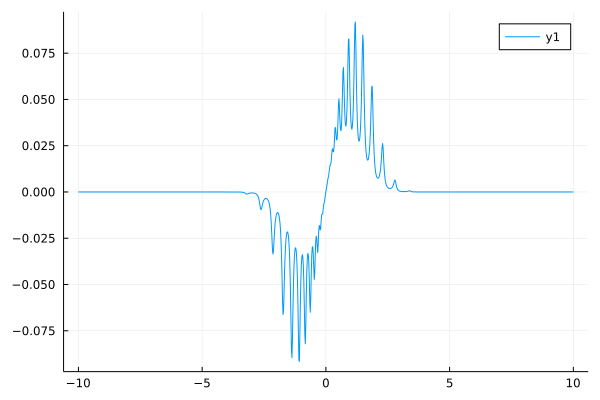

In [17]:
plot(real.(raw_reals.freq), imag.(raw_reals.val/pi).*tanh.(0.5*beta*real.(raw_reals.freq)))

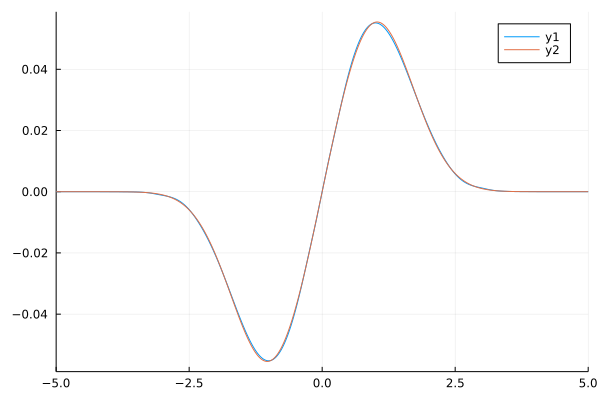

In [21]:
plot(xlim = [-5,5])
#plot!(real.(raw_reals.freq), imag.(raw_reals.val/pi).*tanh.(0.5*beta*real.(raw_reals.freq)))
plot!(Float64.(real.((sol.reals.freq))), Float64.(imag.(sol.reals.val)).*tanh.(0.5*beta*real.(sol.reals.freq))/pi)
plot!(omegas, rho.(omegas).*tanh.(0.5*beta*omegas))

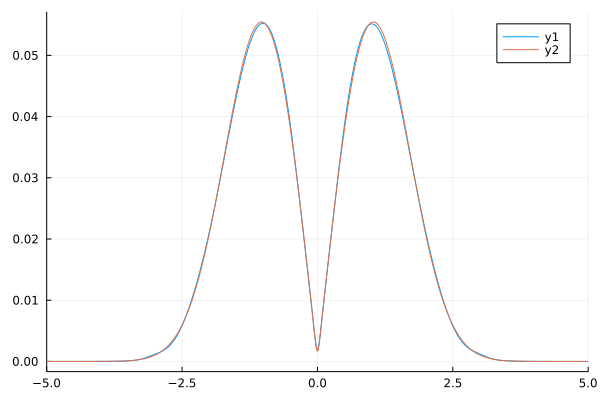

In [23]:
plot(xlim = [-5,5])
#plot!(real.(raw_reals.freq), imag.(raw_reals.val/pi))
plot!(Float64.(real.((sol.reals.freq))), Float64.(imag.(sol.reals.val))/pi)
plot!(omegas, rho.(omegas))